<a href="https://colab.research.google.com/github/Goodnight77/models/blob/master/bayarconv2_model_lastver_with_ppm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammedarbi","key":"7e927abfa5794a9ec08efae5c9996376"}'}

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Replace 'dataset-name' with the actual Kaggle dataset name
!kaggle datasets download -d mohamedbenticha/tsyp-cs-challenge

100% 19.5G/19.5G [01:41<00:00, 95.2MB/s]
100% 19.5G/19.5G [01:41<00:00, 207MB/s] 


In [5]:
!unzip -q tsyp-cs-challenge.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow import keras

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

#hedha_trainable_filtre_li_chnapplikiweh_3a_tasiwra
class BayarConv2d(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=0):
        super(BayarConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.minus1 = tf.ones((self.in_channels, self.out_channels, 1)) * -1.000

        # only (kernel_size ** 2 - 1) trainable params as the center element is always -1
        self.kernel = self.add_weight(shape=(self.in_channels, self.out_channels, kernel_size ** 2 - 1),
                                      initializer='random_normal',
                                      trainable=True)

    def bayarConstraint(self):
        kernel_permuted = tf.transpose(self.kernel, perm=[2, 0, 1])
        kernel_sum = tf.reduce_sum(kernel_permuted, axis=0)
        ctr = self.kernel_size ** 2 // 2
        real_kernel = tf.concat([self.kernel[:, :, :ctr], self.minus1, self.kernel[:, :, ctr:]], axis=2)
        real_kernel = tf.reshape(real_kernel, (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        return real_kernel

    def call(self, x):
        x = tf.nn.conv2d(x, self.bayarConstraint(), strides=self.stride, padding='SAME')
        return x

In [9]:
def conv3x3(out_planes, stride=1):
    return tf.keras.layers.Conv2D(out_planes, kernel_size=3, strides=stride, padding='same', use_bias=False)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

class PyramidPoolingModule(layers.Layer):
    def __init__(self, num_filters=1, kernel_size=(1, 1), bin_sizes=[1, 2, 3, 6], pool_mode='avg', **kwargs):
        super(PyramidPoolingModule, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.bin_sizes = bin_sizes
        self.pool_mode = pool_mode
        self.pyramid_pooling = self.build_pyramid_pooling()

    def build_pyramid_pooling(self):
        return PyramidPoolingModule.PyramidPoolingModule(
            num_filters=self.num_filters,
            kernel_size=self.kernel_size,
            bin_sizes=self.bin_sizes,
            pool_mode=self.pool_mode,
        )

    def call(self, inputs):
        return self.pyramid_pooling(inputs)

    class PyramidPoolingModule(layers.Layer):
        def __init__(self, num_filters, kernel_size, bin_sizes, pool_mode, **kwargs):
            super(PyramidPoolingModule.PyramidPoolingModule, self).__init__(**kwargs)
            self.num_filters = num_filters
            self.kernel_size = kernel_size
            self.bin_sizes = bin_sizes
            self.pool_mode = pool_mode
            self.pyramid_layers = []

            for bin_size in bin_sizes:
                self.pyramid_layers.append(
                    layers.Conv2D(
                        filters=num_filters,
                        kernel_size=kernel_size,
                        padding='same',
                        activation='relu'
                    )
                )

        def call(self, inputs):
            outputs = [inputs]

            for i, bin_size in enumerate(self.bin_sizes):
                pooled = tf.keras.layers.AveragePooling2D(pool_size=(bin_size, bin_size))(inputs)
                convolved = self.pyramid_layers[i](pooled)
                resized = tf.image.resize(convolved, tf.shape(inputs)[1:3])
                outputs.append(resized)

            return tf.concat(outputs, axis=-1)

In [14]:
!pip install keras-resnet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20457 sha256=310ee006a25546044f8655dd390510f0b824d3b2d8b7ca63a6c570b538bb7dc5
  Stored in directory: /root/.cache/pip/wheels/16/af/88/a668b279c5eadbe55dcaf6207f09059135166cefb09088bacc
Successfully built keras-resnet


In [ ]:
import tensorflow.keras as keras
from keras_resnet import models as resnet_models

def buildEncoder(input_shape = (256,256,3)):
    try:
            encoder_model = None

            resnext = resnet_models.ResNext50(input_shape=input_shape)
            # Get list of layer names for skip connections later
            layer_names = [layer.name for layer in resnext.layers]

            # Get layer outputs
            all_layer_outputs = [
                resnext.get_layer(layer_name).output for layer_name in layer_names
            ]

            # Create encoder model
            encoder_model = keras.Model(inputs=resnext.input, outputs=all_layer_outputs)

          # Freeze layers
            encoder_model.trainable = False

    except Exception as e:
            print((f"Unable to buildEncoder!\n{e}"))

    return encoder_model

In [28]:
def buildUnet(input_shape=(256,256,3), dropout_training=True):

        try:
            # =============
            #  Input layer
            # =============

            unet_input = keras.Input(
                shape=input_shape, name="unet_input_layer"
            )

            x = unet_input

            # ===============
            #  BayarConv2d
            # ===============

            # Initialize an instance of BayarConv2d
            in_channels = 3
            out_channels = 32
            kernel_size = 3
            stride = 1
            padding = 0
            bayar_conv = BayarConv2d(in_channels, out_channels, kernel_size, stride, padding)

            # Pass the input tensor through the BayarConv2d layer
            x = bayar_conv(x)

            # =========
            #  Encoder
            # =========

            encoder_model = buildEncoder(input_shape)
            all_encoder_layer_outputs = encoder_model(x)

            # Get final encoder output (this will be the input for the decoder)
            encoded_img = all_encoder_layer_outputs[-1]

            # Get outputs to be used for skip connections
            # (I know the specific layers to be used for skip connections)
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5, 9, 13, 17]]

            # =========
            #  Decoder
            # =========

            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=1,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="sigmoid",
            )(decoded_img)

            ppm = PyramidPoolingModule()
            output_tensor = ppm(encoded_img)
            output_tensor = conv3x3(out_planes=3)(output_tensor)
            avg_pooled = keras.layers.GlobalAveragePooling2D()(output_tensor)
            classification_output = keras.layers.Dense(
                1, activation="sigmoid", name="classification_output"
            )(avg_pooled)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=[final_img, classification_output], name="Unet_VGG16")

            return unet

        except Exception as e:
            print((f"Unable to buildUnet!\n{e}"))

In [29]:
def conv3x3(encoder_model, out_planes):
  conv_output = encoder_model.get_layer(layer_name).output
  return keras.layers.Conv2D(
      filters=out_planes, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(conv_output)


In [30]:
# Create two encoder models using the buildEncoder function
encoder_model1 = buildEncoder()
encoder_model2 = buildEncoder()

Unable to buildEncoder!
module 'keras_resnet.models' has no attribute 'ResNext50'
Unable to buildEncoder!
module 'keras_resnet.models' has no attribute 'ResNext50'


In [22]:


# Get the convolutional layer names for skip connections
conv_layer_names = [layer.name for layer in encoder_model1.layers if isinstance(layer, keras.layers.Conv2D)]

# Initialize a list to store the concatenated convolutional layer outputs
concatenated_conv_outputs = []

# Iterate over the convolutional layer names
for layer_name in conv_layer_names:
    # Get the convolutional layer output from the first encoder
    conv_output1 = encoder_model1.get_layer(layer_name).output

    # Get the convolutional layer output from the second encoder
    conv_output2 = encoder_model2.get_layer(layer_name).output

    # Concatenate the convolutional layer outputs
    concatenated_conv_output = keras.layers.Concatenate()([conv_output1, conv_output2])

    # Pass the concatenated output through the conv3x3 function
    conv_output = conv3x3(out_planes=3)(concatenated_conv_output)

    # Append the conv_output to the list
    concatenated_conv_outputs.append(conv_output)

# Create an instance of the PyramidPoolingModule
ppm = PyramidPoolingModule()

# Forward pass through the Pyramid Pooling Module
output_tensor = ppm(concatenated_conv_outputs[-1])

# Print the output shape
print("Output shape:", output_tensor.shape)

Unable to buildEncoder!
module 'keras_resnet.models' has no attribute 'ResNext50'


UnboundLocalError: ignored

In [38]:
model = buildUnet(input_shape=(256, 256, 3))

In [39]:
model.summary()

Model: "Unet_VGG16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 unet_input_layer (InputLay  [(None, 256, 256, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 bayar_conv2d (BayarConv2d)  (None, 256, 256, 3)          768       ['unet_input_layer[0][0]']    
                                                                                                  
 model_2 (Functional)        [(None, 256, 256, 3),        1471468   ['bayar_conv2d[0][0]']        
                              (None, 256, 256, 64),       8                                       
                              (None, 256, 256, 64),                                      

### data

In [46]:
import pandas as pd
train = pd.read_csv("/content/TSYP/train.csv")
train.tail()

,image,mask,edge,class
18673,final data/DEEPFAKE/image/NeuralTextures/Neura...,final data/DEEPFAKE/mask/NeuralTextures/Neural...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18674,final data/DEEPFAKE/image/NeuralTextures/Neura...,final data/DEEPFAKE/mask/NeuralTextures/Neural...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18675,final data/DEEPFAKE/image/NeuralTextures/Neura...,final data/DEEPFAKE/mask/NeuralTextures/Neural...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18676,final data/DEEPFAKE/image/NeuralTextures/Neura...,final data/DEEPFAKE/mask/NeuralTextures/Neural...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18677,final data/DEEPFAKE/image/NeuralTextures/Neura...,final data/DEEPFAKE/mask/NeuralTextures/Neural...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1


In [47]:
# prompt: want to concatenate on the axis =1 the train and 60% of the test this portion must be taken randomly

train = pd.read_csv("/content/TSYP/train.csv")
test = pd.read_csv("/content/test.csv")

In [48]:
train["image"] = "/content/TSYP/" + train["image"]
train["mask"] = "/content/TSYP/" + train["mask"]
train.fillna("/content/TSYP/mask.png", inplace=True)

In [49]:
val = pd.read_csv("/content/TSYP/val.csv")
val["image"] = "/content/TSYP/" + val["image"]
val["mask"] = "/content/TSYP/" + val["mask"]
val.fillna("/content/TSYP/mask.png", inplace=True)

In [50]:
test = pd.read_csv("/content/test.csv")
test["image"] = "/content/TSYP/" + test["image_paths"]
test['mask_paths'].fillna("/content/TSYP/mask.png", inplace=True)

test['image'] = test['image_paths'].str.replace('C://Users//MSI//Desktop//TSYP challenge//cs//data//', 'final data/')
test['mask'] = test['mask_paths'].str.replace('C://Users//MSI//Desktop//TSYP challenge//cs//data//', 'final data/')

test.to_csv('test1.csv', index=False)

In [51]:
test1 = pd.read_csv("/content/test1.csv")
test1.fillna("/content/TSYP/mask.png", inplace=True)
test1.drop(['image_paths', 'mask_paths','labels','edge_paths'], axis=1, inplace=True)

In [52]:
df = pd.concat([train, test1.sample(frac=0.6)], ignore_index=True)

In [53]:
df

,image,mask,edge,class
0,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0.0
1,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0.0
2,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0.0
3,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0.0
4,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0.0
...,...,...,...,...
23460,final data/ICNC2023-Deepfakes/image/NeuralText...,final data/ICNC2023-Deepfakes/mask/NeuralTextu...,NaN,NaN
23461,final data/ICNC2023-Deepfakes/image/Face2Face/...,final data/ICNC2023-Deepfakes/mask/Face2Face/F...,NaN,NaN
23462,final data/ICNC2023-Deepfakes/image/actors/act...,None,NaN,NaN
23463,final data/ICNC2023-Deepfakes/image/Deepfakes/...,final data/ICNC2023-Deepfakes/mask/Deepfakes/D...,NaN,NaN


In [ ]:
test1.head()

,edge_paths,labels,image,mask
0,None,0,final data/shallowfake/CASIAv2//images/Au/Au_a...,None
1,None,0,final data/shallowfake/CASIAv2//images/Au/Au_p...,None
2,None,0,final data/shallowfake/CASIAv2//images/Au/Au_c...,None
3,None,0,final data/shallowfake/CASIAv2//images/Au/Au_c...,None
4,None,0,final data/shallowfake/CASIAv2//images/Au/Au_s...,None


In [ ]:
train

,image,mask,edge,class
0,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
1,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
2,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
3,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
4,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
...,...,...,...,...
18673,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18674,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18675,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
18676,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1


In [ ]:
val

,image,mask,edge,class
0,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
1,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
2,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
3,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
4,/content/TSYP/final data/SHALLOWFAKE/CASIAv2//...,/content/TSYP/mask.png,/content/TSYP/mask.png,0
...,...,...,...,...
4387,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
4388,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
4389,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1
4390,/content/TSYP/final data/DEEPFAKE/image/Neural...,/content/TSYP/final data/DEEPFAKE/mask/NeuralT...,final data/DEEPFAKE/edge/NeuralTextures/Neural...,1


### valve filter

In [25]:
import numpy as np
import cv2
class ValveFilter:
    def __init__(self, image, roi_map):
        self.image = image
        self.roi_map = roi_map

        # Convert the ROI map to a binary image.
        self.binary_roi_map = np.where(self.roi_map > 0, 1, 0)

        # Convert the binary ROI map to the same format as the image.
        # This ensures compatibility when applying the filter.
        self.binary_roi_map = self.binary_roi_map.astype(self.image.dtype)

        # Create a convolution kernel for the valve filter.
        self.valve_kernel = np.ones([3, 3], dtype=np.float32)

    def filter(self):
        # Convolve the image and the ROI map to create the feature map and relevance map, respectively.
        feature_map = cv2.filter2D(self.image, -1, self.valve_kernel)
        relevance_map = cv2.filter2D(self.binary_roi_map, -1, self.valve_kernel)

        # Normalize the feature map by the relevance map.
        normalized_feature_map = feature_map / (relevance_map + 1e-6)

        return normalized_feature_map

In [40]:
path='/content/drive/MyDrive/CS_Chapter/images/FaceSwap_052_108_16.png'
import tensorflow as tf
from tensorflow.keras import layers, models

# Image input
input_image = layers.Input(shape=(128, 128, 3))

# ROI input
input_roi = layers.Input(shape=(128, 128, 1))

# Convolutional layer with Bias
conv_image = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
conv_image = layers.BatchNormalization()(conv_image)

# Convolutional layer with Valve Filters
conv_roi = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_roi)
conv_roi = layers.BatchNormalization()(conv_roi)

# Multiply the feature maps
mult_features = layers.Multiply()([conv_image, conv_roi])

# ReLU activation
relu_features = layers.ReLU()(mult_features)

#CNN
conv_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(relu_features)
conv_2 = layers.BatchNormalization()(conv_2)

conv_3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2)
conv_3 = layers.BatchNormalization()(conv_3)

# Pool the feature maps
pool_features = layers.MaxPooling2D((2, 2))(conv_3)

# Flatten the feature maps
flatten_features = layers.Flatten()(pool_features)

# Fully connected layer with ReLU activation
dense_1 = layers.Dense(256, activation='relu')(flatten_features)
dense_1 = layers.BatchNormalization()(dense_1)

# Dropout layer to prevent overfitting
dropout_1 = layers.Dropout(0.5)(dense_1)

# Final fully connected layer for prediction
output = layers.Dense(2, activation='softmax')(dropout_1)

# Create the model
model = models.Model(inputs=[input_image, input_roi], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 64)         640       ['input_5[0][0]']             
                                                                                            

In [28]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []
        labels = []

        for _, row in batch_data.iterrows():
            image = load_img(row['image'], target_size=(256, 256))
            image = img_to_array(image) / 255.0
            images.append(image)

            mask = load_img(row['mask'], target_size=(256, 256), color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            masks.append(mask)

            labels.append(row['class'])

        images = np.array(images)
        masks = np.array(masks)
        labels = np.array(labels)

        return images, [masks, labels]

    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1)

NameError: ignored

In [ ]:
train_generator = DataGenerator(train)

In [29]:
val_generator = DataGenerator(val)

NameError: ignored

In [30]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

In [ ]:
model.compile(optimizer='adam', loss=[bce_dice_loss, 'binary_crossentropy'], loss_weights=[0.16, 0.04])

In [ ]:
#loss_weights=[0.16, 0.04]

In [ ]:
model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/50
584/584 [==============================] - ETA: 0s - loss: 0.1762 - final_up_conv_loss: 0.9357 - classification_output_loss: 0.6636
Epoch 1: val_loss improved from inf to 0.14056, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


584/584 [==============================] - 438s 725ms/step - loss: 0.1762 - final_up_conv_loss: 0.9357 - classification_output_loss: 0.6636 - val_loss: 0.1406 - val_final_up_conv_loss: 0.7156 - val_classification_output_loss: 0.6514
Epoch 2/50
584/584 [==============================] - ETA: 0s - loss: 0.1625 - final_up_conv_loss: 0.8548 - classification_output_loss: 0.6429
Epoch 2: val_loss improved from 0.14056 to 0.13378, saving model to best_model.h5
584/584 [==============================] - 417s 714ms/step - loss: 0.1625 - final_up_conv_loss: 0.8548 - classification_output_loss: 0.6429 - val_loss: 0.1338 - val_final_up_conv_loss: 0.6721 - val_classification_output_loss: 0.6561
Epoch 3/50
584/584 [==============================] - ETA: 0s - loss: 0.1590 - final_up_conv_loss: 0.8358 - classification_output_loss: 0.6328
Epoch 3: val_loss improved from 0.13378 to 0.12910, saving model to best_model.h5
584/584 [==============================] - 416s 712ms/step - loss: 0.1590 - final_up

KeyboardInterrupt: ignored

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [135]:
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss
keras.utils.get_custom_objects()['BayarConv2d'] = BayarConv2d
keras.utils.get_custom_objects()['PyramidPoolingModule'] = PyramidPoolingModule

In [ ]:
prediction[0].shape

(256, 256, 1)

In [ ]:
model = load_model('/content/drive/MyDrive/CS_Chapter/deepfake/model.h5')

In [ ]:
model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


584/584 [==============================] - ETA: 0s - loss: 0.1219 - final_up_conv_loss: 0.6285 - classification_output_loss: 0.5334
Epoch 1: val_loss improved from inf to 0.12587, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


584/584 [==============================] - 448s 739ms/step - loss: 0.1219 - final_up_conv_loss: 0.6285 - classification_output_loss: 0.5334 - val_loss: 0.1259 - val_final_up_conv_loss: 0.6215 - val_classification_output_loss: 0.6606
Epoch 2/20
584/584 [==============================] - ETA: 0s - loss: 0.1204 - final_up_conv_loss: 0.6194 - classification_output_loss: 0.5316
Epoch 2: val_loss did not improve from 0.12587
584/584 [==============================] - 420s 718ms/step - loss: 0.1204 - final_up_conv_loss: 0.6194 - classification_output_loss: 0.5316 - val_loss: 0.1324 - val_final_up_conv_loss: 0.6601 - val_classification_output_loss: 0.6692
Epoch 3/20
584/584 [==============================] - ETA: 0s - loss: 0.1190 - final_up_conv_loss: 0.6108 - classification_output_loss: 0.5310
Epoch 3: val_loss improved from 0.12587 to 0.12498, saving model to model.h5
584/584 [==============================] - 418s 715ms/step - loss: 0.1190 - final_up_conv_loss: 0.6108 - classification_outp

In [ ]:
model.save("model_59.h5")

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/model.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/CS_Chapter/deepfake/best_model.h5')
ticha=load_model('/content/drive/MyDrive/CS_Chapter/best_model_ticha.h5')

In [ ]:
from tensorflow import keras

combined_input = keras.Input(shape=(256, 256, 3), name="combined_input")

# Pass the input through the U-Net model

# Update the name of the U-Net model
model = keras.Model(inputs=a, outputs=model[], name=model)
unet_output = model(combined_input)

ppm_output = ticha(combined_input)

# Assuming unet_output is the mask and ppm_output is the classification output
unet_output_mask = unet_output[0]
ppm_output_mask = ppm_output[0]

concatenated_output = keras.layers.Concatenate(axis=-1)([unet_output_mask, ppm_output_mask])
# Update the name of the combined model
combined_model = keras.Model(inputs=combined_input, outputs=concatenated_output, name="Combined_Model")

NameError: ignored

In [ ]:
mask = combined_model.predict(np.expand_dims(input_image, axis=0))

In [ ]:
combined_model.compile(loss='binary_crossentropy', optimizer='adam')


In [ ]:
#train['image'][12]

### youssef model

In [112]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import  concatenate
from tensorflow import keras
import tensorflow as tf
# Pyramid Pooling Module
from tensorflow.keras import layers, models
import numpy as np
class PyramidPoolingModule(tf.keras.layers.Layer):
    def __init__(self, num_filters=1, kernel_size=(1, 1), bin_sizes=[1, 2, 3, 6], pool_mode='avg', **kwargs):
        super(PyramidPoolingModule, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.bin_sizes = bin_sizes
        self.pool_mode = pool_mode
        self.pyramid_pooling = self.build_pyramid_pooling()

    def build_pyramid_pooling(self):
        return PyramidPoolingModule.PyramidPoolingModule(
            num_filters=self.num_filters,
            kernel_size=self.kernel_size,
            bin_sizes=self.bin_sizes,
            pool_mode=self.pool_mode,
        )

    def call(self, inputs):
        return self.pyramid_pooling(inputs)

    class PyramidPoolingModule(tf.keras.layers.Layer):
        def __init__(self, num_filters, kernel_size, bin_sizes, pool_mode, **kwargs):
            super(PyramidPoolingModule.PyramidPoolingModule, self).__init__(**kwargs)
            self.num_filters = num_filters
            self.kernel_size = kernel_size
            self.bin_sizes = bin_sizes
            self.pool_mode = pool_mode
            self.pyramid_layers = []

            for bin_size in bin_sizes:
                self.pyramid_layers.append(
                    layers.Conv2D(
                        filters=num_filters,
                        kernel_size=kernel_size,
                        padding='same',
                        activation='relu'
                    )
                )

        def call(self, inputs):
            outputs = [inputs]

            for i, bin_size in enumerate(self.bin_sizes):
                pooled = tf.keras.layers.AveragePooling2D(pool_size=(bin_size, bin_size))(inputs)
                convolved = self.pyramid_layers[i](pooled)
                resized = tf.image.resize(convolved, tf.shape(inputs)[1:3])
                outputs.append(resized)

            return tf.concat(outputs, axis=-1)
def conv3x3(in_planes, out_planes, stride=1, has_bias=False):
    """
    3x3 convolution with padding
    """
    return tf.keras.layers.Conv2D(
        filters=out_planes,
        kernel_size=(3, 3),
        strides=stride,
        padding='same',
        use_bias=has_bias,
        activation=None  # No activation function (linear activation)
    )

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

class BayarConv2d(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=0):
        super(BayarConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.minus1 = tf.ones((self.in_channels, self.out_channels, 1)) * -1.000

        # only (kernel_size ** 2 - 1) trainable params as the center element is always -1
        self.kernel = self.add_weight(shape=(self.in_channels, self.out_channels, kernel_size ** 2 - 1),
                                      initializer='random_normal',
                                      trainable=True)

    def bayarConstraint(self):
        kernel_permuted = tf.transpose(self.kernel, perm=[2, 0, 1])
        kernel_sum = tf.reduce_sum(kernel_permuted, axis=0)
        ctr = self.kernel_size ** 2 // 2
        real_kernel = tf.concat([self.kernel[:, :, :ctr], self.minus1, self.kernel[:, :, ctr:]], axis=2)
        real_kernel = tf.reshape(real_kernel, (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        return real_kernel

    def call(self, x):
        x = tf.nn.conv2d(x, self.bayarConstraint(), strides=self.stride, padding='SAME')
        return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_encoder(input_shape=(256, 256, 3)):
    # Define the input layer
    inputs = Input(input_shape)

    # Load pre-trained ResNet50 model
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder layers
    s1 = resnet50.layers[0].output         ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)
    b1 = resnet50.get_layer("conv4_block6_out").output
    # Create encoder model
    encoder_model = Model(inputs=inputs, outputs=[s1, s2, s3, s4,b1])

    # Freeze layers
    encoder_model.trainable = False

    return encoder_model

def build_resnet50_unet(input_shape=(256, 256, 3)):
    """ Encoder """
    in_channels= 3
    out_channels = 3
    kernel_size = 3
    stride = 1
    padding = 0
    bayar_conv = BayarConv2d(in_channels, out_channels, kernel_size, stride, padding)
    inputs = Input(input_shape)
    x=bayar_conv(inputs)
    encoder_model = build_encoder(input_shape)
    encoder_layers=encoder_model(inputs)
    encoder_layers_bayer=encoder_model(x)
    num_layers = len(encoder_layers)  # Assuming both lists have the same length
    # Create a list to store the concatenated layers
    concatenated_layers_list = []
    for layer,layer_bayar in zip(encoder_layers, encoder_layers_bayer):
        concatenated_layers=concatenate([layer,layer_bayar], axis=-1)
        output = conv3x3(in_planes=concatenated_layers.shape[-1], out_planes=layer.shape[-1])(concatenated_layers)
        concatenated_layers_list.append(output)
    s1,s2,s3,s4,b1=concatenated_layers_list
    """ Decoder """
    d1 = decoder_block(b1, s4, 256)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 128)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 64)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 32)                      ## (512 x 512)

    """ Output """
    localization_output = Conv2D(1, 1, padding="same", activation="sigmoid",name="localization_output")(d4)
    ppm_output = PyramidPoolingModule()(b1)
    avg_pooled = keras.layers.GlobalAveragePooling2D()(ppm_output)
    classification_output = keras.layers.Dense(
        1, activation="sigmoid", name="classification_output"
    )(avg_pooled)
    model = Model(inputs, outputs=[localization_output,classification_output], name="ResNet50_U-Net")
    return model


In [ ]:
# Usage example
input_shape = (256, 256, 3)
model = build_resnet50_unet(input_shape)
model.summary()

In [124]:
train.shape

(18678, 4)

In [125]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []
        labels = []

        for _, row in batch_data.iterrows():
            image = load_img(row['image'], target_size=(256, 256))
            image = img_to_array(image) / 255.0
            images.append(image)

            mask = load_img(row['mask'], target_size=(256, 256), color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            masks.append(mask)

            labels.append(row['class'])

        images = np.array(images)
        masks = np.array(masks)
        labels = np.array(labels)

        return images, [masks, labels]

    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1)

In [126]:
train_generator = DataGenerator(train)
val_generator = DataGenerator(val)

In [127]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [128]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint("youssef_model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=0.0001, mode='auto', verbose=1)

In [129]:
model.compile(optimizer='adam', loss=[bce_dice_loss, 'binary_crossentropy'], loss_weights=[0.16, 0.04])

In [ ]:
model.compile(optimizer='adam', loss=[bce_dice_loss, 'binary_crossentropy'], loss_weights=[0.16, 0.04])

In [215]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr / 10
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Set SGD hyperparameters as per your requirement
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

tes2.compile(optimizer=sgd_optimizer, loss=[bce_dice_loss, 'binary_crossentropy'], loss_weights=[0.16, 0.04], metrics=['accuracy'])


In [216]:
tes2.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint, lr_scheduler])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


584/584 [==============================] - ETA: 0s - loss: 32.4902 - localization_output_loss: 0.7653 - classification_output_loss: 809.1938 - localization_output_accuracy: 0.9708 - classification_output_accuracy: 0.5488
Epoch 1: val_loss did not improve from 0.12978
584/584 [==============================] - 755s 1s/step - loss: 32.4902 - localization_output_loss: 0.7653 - classification_output_loss: 809.1938 - localization_output_accuracy: 0.9708 - classification_output_accuracy: 0.5488 - val_loss: 5.1932 - val_localization_output_loss: 0.5917 - val_classification_output_loss: 127.4621 - val_localization_output_accuracy: 0.9738 - val_classification_output_accuracy: 0.5644 - lr: 0.0100
Epoch 2/10
584/584 [==============================] - ETA: 0s - loss: 4.3208 - localization_output_loss: 0.7653 - classification_output_loss: 104.9591 - localization_output_accuracy: 0.9706 - classification_output_accuracy: 0.5639
Epoch 2: val_loss did not improve from 0.12978
584/584 [=================

KeyboardInterrupt: ignored

Mounted at /content/drive


In [132]:
save_path = '/content/drive/MyDrive/CS_Chapter/deepfake/test2_model.h5'
model.save(save_path)
print("Model saved successfully to Google Drive.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully to Google Drive.


In [214]:
from tensorflow.keras.models import load_model
tes2=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/test2_model.h5')

In [81]:
from tensorflow.keras.models import load_model
youssef=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/youssef_model.h5')
ticha=load_model('/content/drive/MyDrive/CS_Chapter/best_model_ticha.h5')
model=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/model_37.h5')

In [75]:
test_model=load_model('/content/test_model.h5')

In [ ]:
#best=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/unet-resnet/best_model.h5')

In [ ]:
#l=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/unet-resnet/model-sf-l1-l2.h5')
model_37=load_model('/content/drive/MyDrive/CS_Chapter/deepfake/model_37.h5')

TypeError: ignored

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
image_path = '/content/Sp_D_CNN_A_art0024_ani0032_0268.jpg'
img = image.load_img(image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
outputs_model = model.predict(img_array)
outputs_ticha = ticha.predict(img_array)

combined_localization_output = (outputs_model[0] + outputs_ticha[0]) / 2.0
combined_classification_output = np.maximum(outputs_model[1], outputs_ticha[1])

final_combined_output = [combined_localization_output, combined_classification_output]


ValueError: ignored

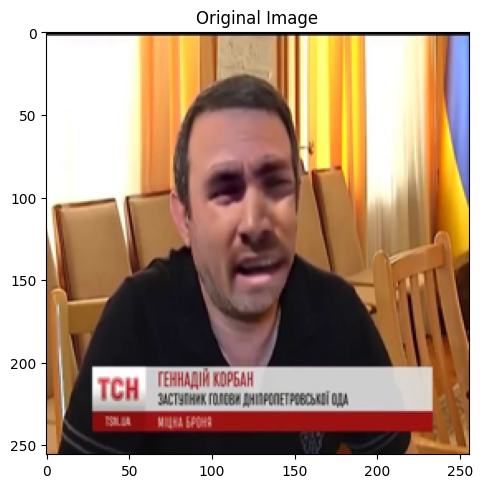

In [ ]:
image = Image.open(image_path).convert('RGB')
image = image.resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')

# Reshape final_combined_output to remove the extra dimension
final_combined_output = np.squeeze(final_combined_output, axis=-1)

plt.subplot(1, 2, 2)
plt.imshow(final_combined_output, cmap='gray')
plt.title('Predicted Mask')
plt.show()

1/1 [==============================] - 0s 29ms/step


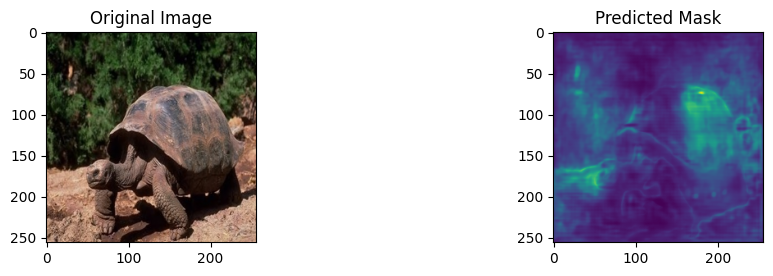

In [219]:
from PIL import Image
import numpy as np
a='/content/drive/MyDrive/CS_Chapter/images/1.tif'
b='/content/drive/MyDrive/CS_Chapter/images/FaceSwap_052_108_16.png'
c='/content/drive/MyDrive/CS_Chapter/images/canong3_canonxt_sub_23.tif'
d='/content/drive/MyDrive/CS_Chapter/images/canong3_nikond70_sub_29.tif'
from PIL import Image
import numpy as np
i=776
path='/content/canong3_kodakdcs330_sub_01.tif'

path='/content/Sp_S_CNN_A_nat0078_nat0078_0004_gt.png'
path='/content/nikond70_kodakdcs330_sub_27.tif'

path=d='/content/drive/MyDrive/CS_Chapter/images/canong3_nikond70_sub_29.tif'
path='/content/Au_ani_0003.jpg'
#path=train['image'][i]
image = Image.open(path).convert('RGB')
image = image.resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)
prediction, classification = tes2.predict(image)

#mask_path=train['mask'][i]
#mask = Image.open(mask_path).convert('RGB')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')


plt.subplot(2, 2, 2)
plt.imshow(prediction[0])
plt.title('Predicted Mask')
plt.show()

In [220]:
classification[0][0]

0.3814694

1/1 [==============================] - 2s 2s/step


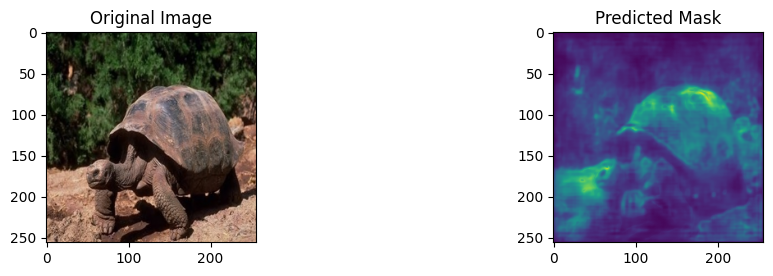

In [221]:
image = Image.open(path).convert('RGB')
image = image.resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)
prediction, classification = model.predict(image)

#mask_path=train['mask'][i]
#mask = Image.open(mask_path).convert('RGB')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')


plt.subplot(2, 2, 2)
plt.imshow(prediction[0])
plt.title('Predicted Mask')
plt.show()

In [222]:
classification[0][0]

1.0

1/1 [==============================] - 0s 22ms/step


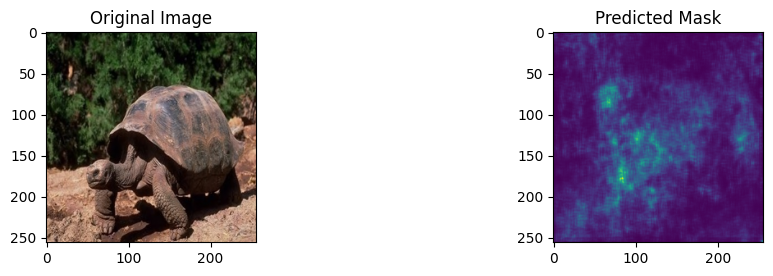

In [223]:
image = Image.open(path).convert('RGB')
image = image.resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)
prediction, classification = ticha.predict(image)

#mask_path=train['mask'][i]
#mask = Image.open(mask_path).convert('RGB')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')


plt.subplot(2, 2, 2)
plt.imshow(prediction[0])
plt.title('Predicted Mask')
plt.show()

In [224]:
classification[0][0]

0.4834513

1/1 [==============================] - 0s 27ms/step


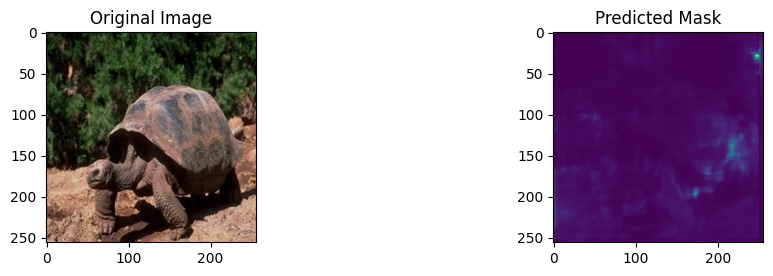

In [225]:
image = Image.open(path).convert('RGB')
image = image.resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0)
prediction, classification = youssef.predict(image)

#mask_path=train['mask'][i]
#mask = Image.open(mask_path).convert('RGB')
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')


plt.subplot(2, 2, 2)
plt.imshow(prediction[0])
plt.title('Predicted Mask')
plt.show()

In [226]:
classification[0][0]

0.19072647

In [201]:
#youssef better in classification
#tes2 better fl segmentation